In [1]:
import os
import numpy as np
import pandas as pd
import collections
import random
import pprint
import time
import matplotlib.pyplot as plt
import choix
from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from scipy import stats

## Lets define some functions first

In [2]:
def MapImagesToIndexes(df):
    image_ids = list(set(df['image1'].tolist() + df['image2'].tolist()))
    int_to_idx = dict(enumerate(image_ids))
    idx_to_int = dict((v, k) for k, v in int_to_idx.items())
    return int_to_idx, idx_to_int

def GenrateChoixData(df, idx_to_int):
    # make data for choix.opt_pairwise
    pairs = []
    for row in df.iterrows():
        id1 = idx_to_int[row[1]['image1']]
        id2 = idx_to_int[row[1]['image2']]
        win1 = row[1]['win1']
        win2 = row[1]['win2']
        tie = row[1]['tie']
        for _ in range(win1):
            pairs.append((id1, id2))
            pairs.append((id1, id2))
        for _ in range(win2):
            pairs.append((id2, id1))
            pairs.append((id2, id1))
        for _ in range(tie):
            pairs.append((id1, id2))
            pairs.append((id2, id1))
    return pairs

def GenerateChoixScores(df, csvPath):
    int_to_idx, idx_to_int = MapImagesToIndexes(df)
    n_items = len(idx_to_int)
    pairs = GenrateChoixData(df, idx_to_int)
    start_time = time.time()
    params = choix.opt_pairwise(n_items, pairs)
    df = pd.DataFrame(params)
    df['fname'] = [int_to_idx[i] for i in df.index]
    df.to_csv(csvPath)
    print(time.time() - start_time)
    
def ReadScoresFromCsv(csvPath):
    # min-max scaling
    df = pd.read_csv(csvPath, index_col=0)
    df.columns = ['violence', 'fname']
    return df

def MinMax(df, column):
    df_result = df.copy()
    v = np.matrix(df_result[column])
    scaler = MinMaxScaler()
    df_result[column] = scaler.fit_transform(v.T)
    return df_result

def ClipValues(df, cutpoint):
    df_result = df.copy()
    ix_large = df_result[df_result['violence'] > cutpoint].index
    df_result.loc[ix_large, 'violence'] = cutpoint
    return df_result

## Lets read in the data

In [3]:
UCLA_csv = "../misc/pairwise_annot.csv"
luca_csv = "../misc/pairwise_annot_luca_ecb.csv"

In [4]:
df_UCLA_raw = pd.read_csv(UCLA_csv, index_col=0)
df_luca_raw = pd.read_csv(luca_csv, index_col=0)

## First, lets process image raw scores

In [5]:
UCLA_csv_out = "UCLA_raw_scores.csv"
luca_csv_out = "luca_1000_raw_scores.csv"
if not os.path.exists(UCLA_csv_out):
    GenerateChoixScores(df_UCLA_raw, UCLA_csv_out)
    
if not os.path.exists(luca_csv_out):
    GenerateChoixScores(df_luca_raw, luca_csv_out)

In [6]:
# read scores and mini max them
df_UCLA = MinMax(ReadScoresFromCsv(UCLA_csv_out), "violence")
df_luca = MinMax(ReadScoresFromCsv(luca_csv_out), "violence")

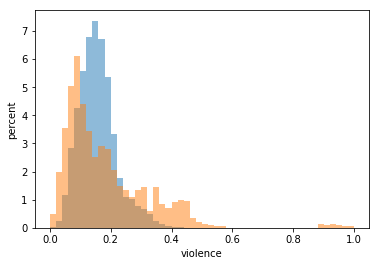

In [7]:
# check distribution
plt.hist(df_UCLA['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

Below here we use the Kolmogorov–Smirnov to evaluate if both distributions come from the same population. The interpretation of the p value according to https://www.graphpad.com/guides/prism/7/statistics/interpreting_results_kolmogorov-smirnov_test.htm?toc=0&printWindow is as follows:

"If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed?"

In [11]:
print(stats.ks_2samp(df_UCLA['violence'], df_luca['violence']).pvalue)

7.228869847691746e-27


Uuuh, it does not look like they come from the same distribution

## Now, lets do the same considering we clip it

In [9]:
df_UCLA_clipped = MinMax(ClipValues(df_UCLA, 0.43), 'violence')
df_luca_clipped = MinMax(ClipValues(df_luca, 0.62), 'violence')

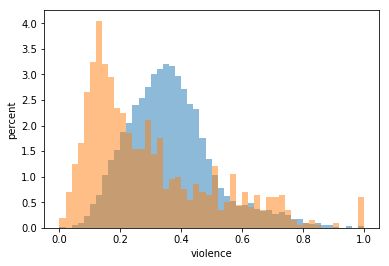

In [10]:
# check distribution
plt.hist(df_UCLA_clipped['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca_clipped['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

In [12]:
print(stats.ks_2samp(df_UCLA_clipped['violence'], df_luca_clipped['violence']).pvalue)

4.4701117925180545e-98


Uhhhh x2, even worst. Definitely not the same distribution

## All right, now lets have a look at the effect of clipping

### First lets look at UCLA

In [41]:
UCLA_very_violent = df_UCLA[df_UCLA['violence'] > 0.43]
UCLA_cut_point = df_UCLA[(df_UCLA['violence'] <= 0.43) & (df_UCLA['violence'] >= 0.38) ]

In [52]:
images_dir = "../images"
images_to_print = 5

### Ivestigating mages close to 1

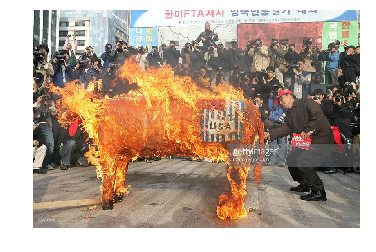

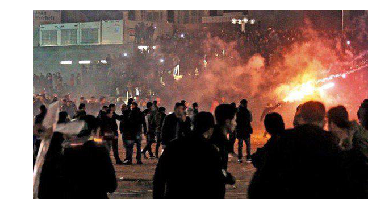

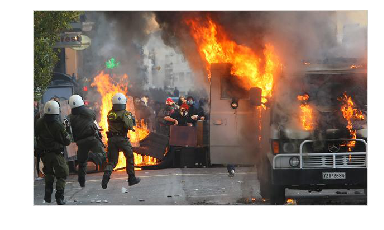

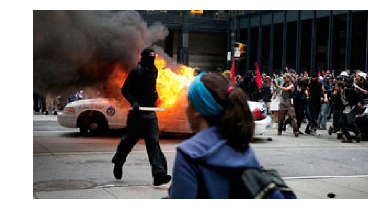

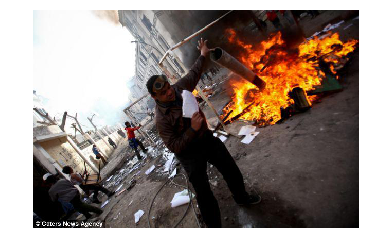

In [55]:
img_paths = UCLA_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Ivestigating mages close to the cut point

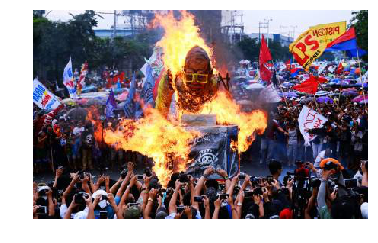

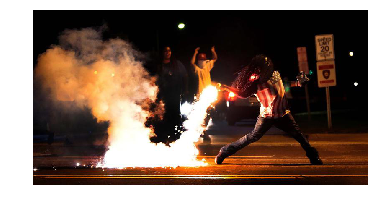

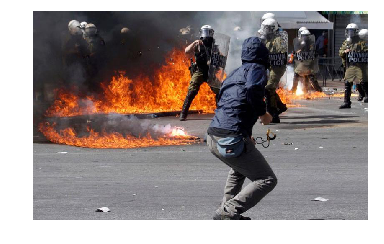

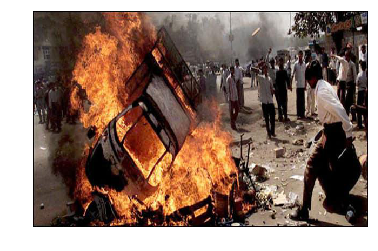

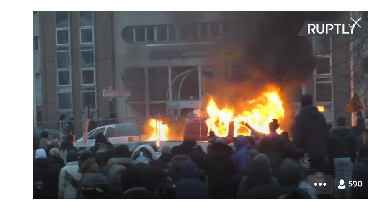

In [56]:
img_paths = UCLA_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Images close to 1 do not seem to differ much from the images that are close to our clipping point. This indicates that we probably should treat them as outliners in terms of scores. In other words, pulling their scores closer to each other should not cause us a lost in precision in the range of violence

### Now lets look at Luca data

In [62]:
luca_very_violent = df_luca[df_luca['violence'] > 0.6]
luca_cut_point = df_luca[(df_luca['violence'] <= 0.6) & (df_luca['violence'] >= 0.5) ]

### Ivestigating mages close to 1

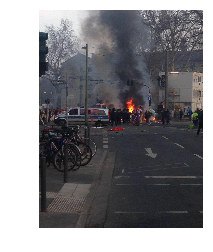

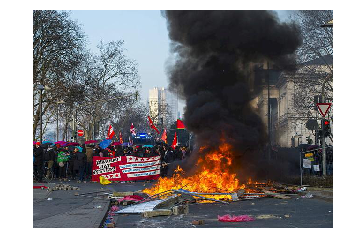

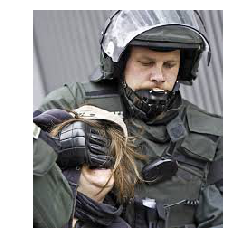

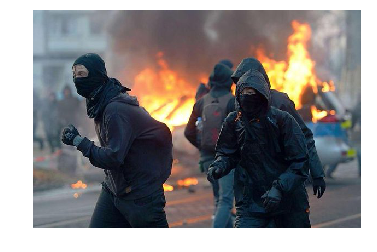

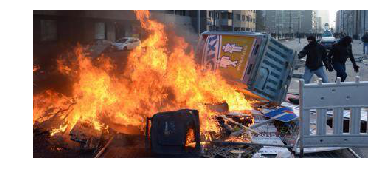

In [60]:
img_paths = luca_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Ivestigating mages close to the cut point

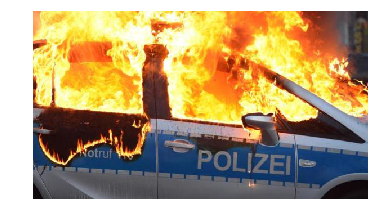

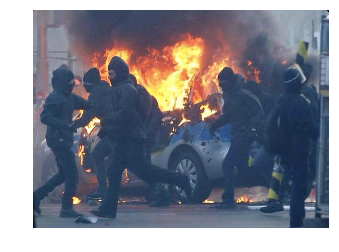

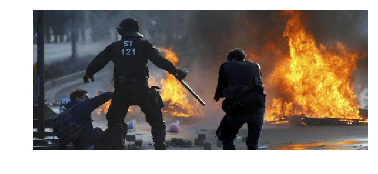

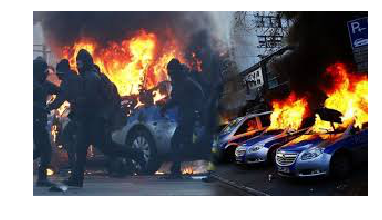

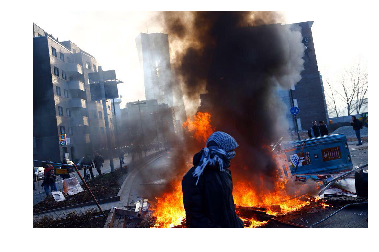

In [63]:
img_paths = luca_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

It seems that the statement above also holds for Luca's dataset